# Unit Root Testing

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

## Setup

Most examples will make use of the Default premium, which is the difference between the yields of BAA and AAA rated corporate bonds. The data is downloaded from FRED using pandas.

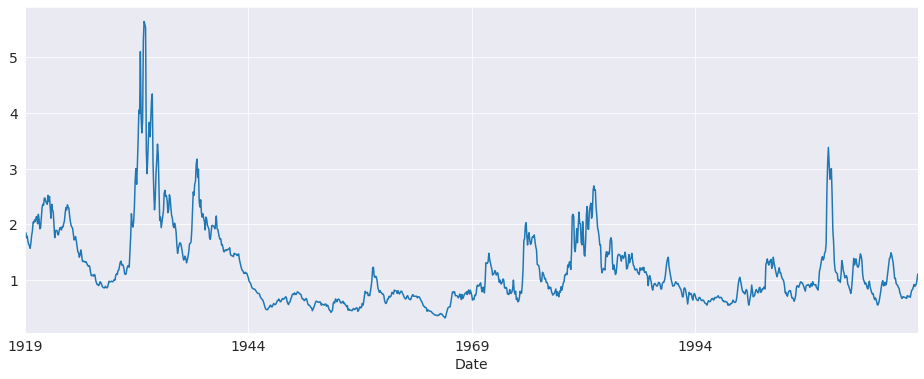

In [2]:
import pandas as pd
import statsmodels.api as sm

import arch.data.default

default_data = arch.data.default.load()
default = default_data.BAA.copy()
default.name = 'default'
default = default - default_data.AAA.values
fig = default.plot()

The Default premium is clearly highly persistent.  A simple check of the autocorrelations confirms this.

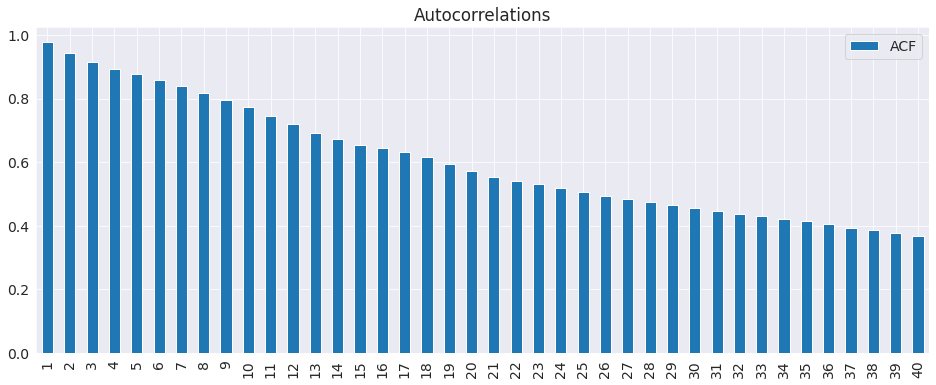

In [3]:
acf = pd.DataFrame(sm.tsa.stattools.acf(default), columns=['ACF'])
fig = acf[1:].plot(kind='bar', title='Autocorrelations')

## Augmented Dickey-Fuller Testing

The Augmented Dickey-Fuller test is the most common unit root test used.  It is a regression of the first difference of the variable  on its lagged level as well as additional lags of the first difference.  The null is that the series contains a unit root, and the (one-sided) alternative is that the series is stationary. 

By default, the number of lags is selected by minimizing the AIC across a range of lag lengths (which can be set using `max_lag` when initializing the model).  Additionally, the basic test includes a constant in the ADF regression.

These results indicate that the Default premium is stationary.

In [4]:
from arch.unitroot import ADF

adf = ADF(default)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.356
P-value                         0.013
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The number of lags can be directly set using `lags`.  Changing the number of lags makes no difference to the conclusion.

**Note**: The ADF assumes residuals are white noise, and that the number of lags is sufficient to pick up any dependence in the data.

### Setting the number of lags

In [5]:
adf.lags = 5
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.582
P-value                         0.006
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Deterministic terms

The deterministic terms can be altered using `trend`.  The options are:

* `'nc'` : No deterministic terms
* `'c'` : Constant only
* `'ct'` : Constant and time trend
* `'ctt'` : Constant, time trend and time-trend squared

Changing the type of constant also makes no difference for this data.

In [6]:
adf.trend = 'ct'
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.786
P-value                         0.017
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Regression output

The ADF uses a standard regression when computing results.  These can be accesses using `regression`.

In [7]:
reg_res = adf.regression
print(reg_res.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     17.83
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           1.30e-22
Time:                        12:04:02   Log-Likelihood:                 630.15
No. Observations:                1194   AIC:                            -1244.
Df Residuals:                    1186   BIC:                            -1204.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.0248      0.007     -3.786      0.0

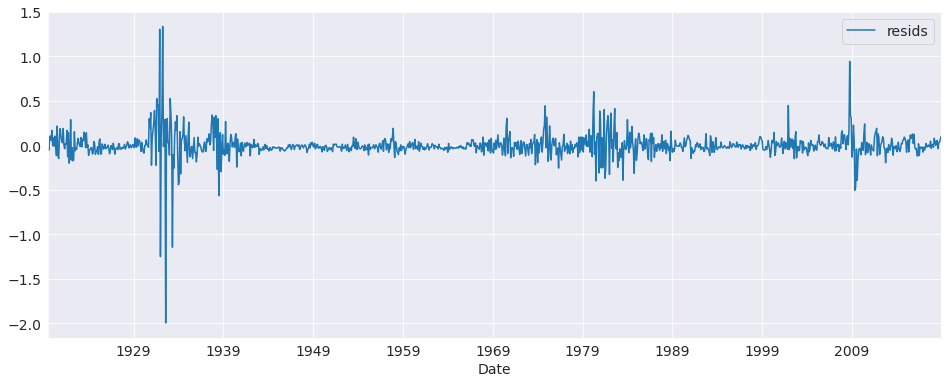

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

resids = pd.DataFrame(reg_res.resid)
resids.index = default.index[6:]
resids.columns = ['resids']
fig = resids.plot()

Since the number lags was directly set, it is good to check whether the residuals appear to be white noise.

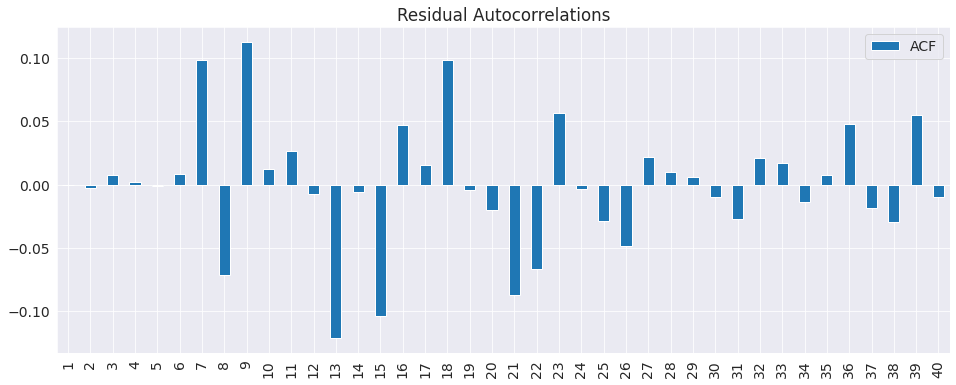

In [9]:
acf = pd.DataFrame(sm.tsa.stattools.acf(reg_res.resid), columns=['ACF'])
fig = acf[1:].plot(kind='bar', title='Residual Autocorrelations')

## Dickey-Fuller GLS Testing

The Dickey-Fuller GLS test is an improved version of the ADF which uses a GLS-detrending regression before running an ADF regression with no additional deterministic terms.  This test is only available with a constant or constant and time trend (`trend='c'` or  `trend='ct'`).

The results of this test agree with the ADF results.

In [10]:
from arch.unitroot import DFGLS

dfgls = DFGLS(default)
print(dfgls.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -2.322
P-value                         0.020
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -2.59 (1%), -1.96 (5%), -1.64 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The trend can be altered using `trend`.  The conclusion is the same. 

In [11]:
dfgls.trend = 'ct'
print(dfgls.summary().as_text())

      Dickey-Fuller GLS Results      
Test Statistic                 -3.464
P-value                         0.009
Lags                               21
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.43 (1%), -2.86 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Phillips-Perron Testing

The Phillips-Perron test is similar to the ADF except that the regression run does not include lagged values of the first differences.  Instead, the PP test fixed the t-statistic using a long run variance estimation, implemented using a Newey-West covariance estimator.  

By default, the number of lags is automatically set, although this can be overridden using `lags`.

In [12]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(default)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.898
P-value                         0.002
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


It is important that the number of lags is sufficient to pick up any dependence in the data.

In [13]:
pp.lags = 12
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.024
P-value                         0.001
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


The trend can be changed as well.

In [14]:
pp.trend = 'ct'
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.262
P-value                         0.004
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Finally, the PP testing framework includes two types of tests. One which uses an ADF-type regression of the first difference on the level, the other which regresses the level on the level.  The default is the `tau` test, which is similar to an ADF regression, although this can be changed using `test_type='rho'`.

In [15]:
pp.test_type = 'rho'
print(pp.summary().as_text())

     Phillips-Perron Test (Z-rho)    
Test Statistic                -36.114
P-value                         0.002
Lags                               12
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.16 (1%), -21.60 (5%), -18.17 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## KPSS Testing

The KPSS test differs from the three previous in that the null is a stationary process and the alternative is a unit root.  

Note that here the null is rejected which indicates that the series might be a unit root.

In [16]:
from arch.unitroot import KPSS

kpss = KPSS(default)
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  1.088
P-value                         0.002
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Changing the trend does not alter the conclusion.

In [17]:
kpss.trend = 'ct'
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.393
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


## Zivot-Andrews Test

The Zivot-Andrews test allows the possibility of a single structural break in the series. Here we test the default using the test.

In [18]:
from arch.unitroot import ZivotAndrews

za = ZivotAndrews(default)
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -4.900
P-value                         0.040
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## Variance Ratio Testing

Variance ratio tests are not usually used as unit root tests, and are instead used for testing whether a financial return series is a pure random walk versus having some predictability.  This example uses the excess return on the market from Ken French's data. 

In [19]:
import numpy as np
import pandas as pd
import arch.data.frenchdata
ff = arch.data.frenchdata.load()
excess_market = ff.iloc[:, 0]  # Excess Market
print(ff.describe())

            Mkt-RF          SMB          HML           RF
count  1109.000000  1109.000000  1109.000000  1109.000000
mean      0.659946     0.206555     0.368864     0.274220
std       5.327524     3.191132     3.482352     0.253377
min     -29.130000   -16.870000   -13.280000    -0.060000
25%      -1.970000    -1.560000    -1.320000     0.030000
50%       1.020000     0.070000     0.140000     0.230000
75%       3.610000     1.730000     1.740000     0.430000
max      38.850000    36.700000    35.460000     1.350000


The variance ratio compares the variance of a 1-period return to that of a multi-period return. The comparison length has to be set when initializing the test.  

This example compares 1-month to 12-month returns, and the null that the series is a pure random walk is rejected. Negative values indicate some positive autocorrelation in the returns (momentum).

In [20]:
from arch.unitroot import VarianceRatio
vr = VarianceRatio(excess_market, 12)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                 -5.029
P-value                         0.000
Lags                               12
-------------------------------------

Computed with overlapping blocks (de-biased)


By default the VR test uses all overlapping blocks to estimate the variance of the long period's return.  This can be changed by setting  `overlap=False`.  This lowers the power but does not change the conclusion.

In [21]:
warnings.simplefilter('always')  # Restore warnings

vr = VarianceRatio(excess_market, 12, overlap = False)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                 -6.206
P-value                         0.000
Lags                               12
-------------------------------------

Computed with non-overlapping blocks


/mnt/c/git/arch/arch/unitroot/unitroot.py:1727: InvalidLengthWarning: 
The length of y is not an exact multiple of 12, and so the final
4 observations have been dropped.

  InvalidLengthWarning,


**Note**: The warning is intentional. It appears here since when it is not possible to use all data since the data length is not an integer multiple of the long period when using non-overlapping blocks.  There is little reason to use `overlap=False`.